In [1]:
from lookup_table import LUT
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import PolynomialFeatures
from numpy import polyfit
from collections import Counter
from collections import namedtuple
import PIL
from PIL import Image
from mapping import get_fwd_mapping_H,get_bwd_mapping_H

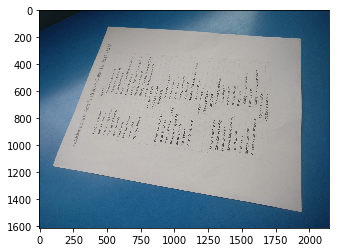

In [2]:
source_image=cv2.imread("./photo.jpg")
plt.imshow(source_image)

In [3]:
x_coords = [1946,105,511,1944]
y_coords = [1499,1159,125,217]# Plot points from the previous problem is used to draw over your image
# Note that your coordinates will change once you resize your image again
source_points = np.vstack((x_coords, y_coords))

In [4]:
def to_homog(points): #here always remember that points is a 3x4 matrix
   # write your code here
    if len(points.shape)==1:
       # only 1 point is passed:
        a=np.ones((len(points)+1),np.float32)
        a[0]=points[0]
        a[1]=points[1]
        return a
    r,c=(points.shape[0]+1,points.shape[1])
    a=np.ones((r,c),type(points[0,0]))
    a[:r-1,:]=points[:,:]
    return a# convert points from homogeneous to euclidian
def from_homog(points_homog):
   # write your code here
    if len(points_homog.shape)==1:
       # only 1 point is passed:
        a=np.zeros((len(points_homog)-1),np.float32)
        a[0]=points_homog[0]/points_homog[2]
        a[1]=points_homog[1]/points_homog[2]
        return a
    n=points_homog.shape[0]-1
    m=points_homog.shape[1]
    b=np.zeros((n,m),np.float32)
    for i in range(n):
        b[i,:]=points_homog[i,:]/points_homog[n,:]    
    return b# project 3D euclidian points to 2D euclidian
def project_points(P_int, P_ext, pts):
   # write your code here
   # assuming P_int is the camera matrix (3x4)
   # P_ext is 4x4
   # pts are 3x1 (non homogenous)
    print(np.shape(P_int))
    print(np.shape(P_ext))
    print(np.shape(to_homog(pts)))
    pts_final=np.matmul(P_int,np.matmul(P_ext,to_homog(pts)))
    return from_homog(pts_final)

In [5]:
def computeH(source_points, target_points):
    # returns the 3x3 homography matrix such that:
    # np.matmul(H, source_points) = target_points
    # where source_points and target_points are expected to be in homogeneous
    # make sure points are 3D homogeneous
    assert source_points.shape[0]==3 and target_points.shape[0]==3
    #Your code goes here
    H_mtx = np.zeros((3,3)) #Fill in the H_mtx with appropriate values.
    #source to e -> H1, e to target -> H2_inv
    # will calculate H1, and H2. Then do H1.H2^-1
    # H1
    xin=source_points.T
    print("XIN",xin)
    xinmat=np.hstack((xin[0,:].reshape(-1,1),xin[1,:].reshape(-1,1),xin[2,:].reshape(-1,1)))
    print("XINMAT",xinmat)
    lambdas1=np.matmul(np.linalg.inv(xinmat),xin[3,:].reshape(-1,1)).reshape(-1)    
    print("LAMBDAS1",lambdas1)
    H1inv=np.hstack((xin[0,:].reshape(-1,1)*lambdas1[0],
                    xin[1,:].reshape(-1,1)*lambdas1[1],
                    xin[2,:].reshape(-1,1)*lambdas1[2]))
    print("H1inv",H1inv)
    xout=target_points.T
    print("XOUT",xout)
    xoutmat=np.hstack((xout[0,:].reshape(-1,1),xout[1,:].reshape(-1,1),xout[2,:].reshape(-1,1)))
    print("XOUTMAT",xoutmat)
    lambdas2=np.matmul(np.linalg.inv(xoutmat),xout[3,:].reshape(-1,1)).reshape(-1)
    print("LAMBDAS2",lambdas2)
    H2inv=np.hstack((xout[0,:].reshape(-1,1)*lambdas2[0],
                   xout[1,:].reshape(-1,1)*lambdas2[1],
                   xout[2,:].reshape(-1,1)*lambdas2[2]))
    print("H2inv",H2inv)
    H_mtx=np.matmul(H2inv,np.linalg.inv(H1inv))
    print("***********")
    return  H_mtx

In [6]:
def distance(x1,y1,x2,y2,metric='l1'):
    if metric=='l1':
        return np.abs(x1-x2)+np.abs(y1-y2)
    if metric=='l2':
        return np.sqrt((x1-x2)**2+(y1-y2)**2)

def n_nearest_neighbours(x,y,n=8,dist='l2'):
    '''Takes a point in 2D space,
    returns n nearest neighbours (n<=15)
    '''
    nn=[]
    fracx=x%1.0
    fracy=y%1.0
    xfloor=np.floor(x)
    yfloor=np.floor(y)
    xceil=np.ceil(x)
    yceil=np.ceil(y)
    window_size=int(np.ceil(np.sqrt(n)))
    xns=set(range(int(xfloor)-int(window_size/2),int(xceil)+int(window_size/2)+1))
    yns=set(range(int(yfloor)-int(window_size/2),int(yceil)+int(window_size/2)+1))
#     xns=set([xfloor-2,xfloor-1,xfloor,xceil,xceil+1,xfloor+2])
#     yns=set([yfloor-1,yfloor,yceil,yceil+1])
        
    for xn in xns:
        for yn in yns:
            a=distance(x,y,xn,yn,metric='l2')
#             print(type(a))
#             print(type(xn))
#             print(type(yn))
            nn.append((a,xn,yn))
    nn=sorted(nn)
    return nn[:n]

In [7]:
def norm(img):
#    assert img.shape[2]==3
    maxi=img.max()
    mini=img.min()
    return (img-mini)/(maxi-mini)

In [8]:
H=get_fwd_mapping_H()

h,w: 1610 2147
[2147. 1610.] [0. 0. 0.]
[   0. 1610.] [0. 0. 0.]
[0. 0.] [0. 0. 0.]
[2147.    0.] [0. 0. 0.]
Source Points coordinates: [[1946  105  511 1944]
 [1499 1159  125  217]]
Target Points coordinates: [[2147.    0.    0. 2147.]
 [1610. 1610.    0.    0.]]
XIN [[1946 1499    1]
 [ 105 1159    1]
 [ 511  125    1]
 [1944  217    1]]
XINMAT [[1946  105  511]
 [1499 1159  125]
 [   1    1    1]]
LAMBDAS1 [ 0.74404815 -0.89973129  1.15568314]
H1inv [[ 1.44791770e+03 -9.44717858e+01  5.90554087e+02]
 [ 1.11532818e+03 -1.04278857e+03  1.44460393e+02]
 [ 7.44048150e-01 -8.99731294e-01  1.15568314e+00]]
XOUT [[2.147e+03 1.610e+03 1.000e+00]
 [0.000e+00 1.610e+03 1.000e+00]
 [0.000e+00 0.000e+00 1.000e+00]
 [2.147e+03 0.000e+00 1.000e+00]]
XOUTMAT [[2.147e+03 0.000e+00 0.000e+00]
 [1.610e+03 1.610e+03 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00]]
LAMBDAS2 [ 1. -1.  1.]
H2inv [[ 2.147e+03 -0.000e+00  0.000e+00]
 [ 1.610e+03 -1.610e+03  0.000e+00]
 [ 1.000e+00 -1.000e+00  1.000e+00]]
*****

In [9]:
tables=LUT(H,source_image.shape)

-1032.7897 2422.374 -405.586 2092.6357


In [15]:
# compress LUT:
'''Original LUT was of size maxy X maxx
We use polynomial approximation to compress this table.
Compress_along_axis = 0
Yf=Pn(Yi)
Pn = F(Xi)
Where Pn is a polynomial of degree n
LUT will become a table of size  maxx X (n+1)
Compress_along_axis = 1
Xf=Pn(Xi)
Pn = F(Yi)
Where Pn is a polynomial of degree n
LUT will become a table of size maxy X (n+1)
'''
maxy,maxx=tables.LUT_fwd_x.shape[:2]
compressed_LUT_yout_fwd=np.zeros((maxy,tables.poly_degree+1))
compressed_LUT_xout_fwd=np.zeros((maxx,tables.poly_degree+1))
for idx in range(maxy):
    _,yu=tables.LUT_fwdf(idx,None)
    x=range(maxx)
    values,residuals, rank, singular_values, rcond=polyfit(x,yu,deg=tables.poly_degree,full=True)
    compressed_LUT_yout_fwd[idx,:]=values

for idx in range(maxx):
    xu,_=tables.LUT_fwdf(None,idx)
    y=range(maxy)
    values,residuals, rank, singular_values, rcond=polyfit(y,xu,deg=tables.poly_degree,full=True)
    compressed_LUT_xout_fwd[idx,:]=values

maxy,maxx=tables.LUT_bwd_x.shape[:2]
LUT_bwd2_y=np.zeros((maxy,tables.poly_degree+1))
LUT_bwd2_x=np.zeros((maxx,tables.poly_degree+1))
for idx in range(maxy):
    _,yu=tables.LUT_bwdf(idx+tables.yrmin,None)
    x=range(maxx)+tables.xrmin
    values,residuals, rank, singular_values, rcond=polyfit(x,yu,deg=tables.poly_degree,full=True)
    LUT_bwd2_y[idx,:]=values
for idx in range(maxx):
    xu,_=tables.LUT_bwdf(None,idx+tables.xrmin)
    y=range(maxy)+tables.yrmin
    values,residuals, rank, singular_values, rcond=polyfit(y,xu,deg=tables.poly_degree,full=True)
    LUT_bwd2_x[idx,:]=values

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.preprocessing import PolynomialFeatures
from numpy import polyfit
from collections import Counter
from collections import namedtuple
import PIL
from PIL import Image

from lookup_table import LUT
from mapping import get_fwd_mapping_H,get_bwd_mapping_H

In [10]:
H=get_fwd_mapping_H()

h,w: 1610 2147
[2147. 1610.] [0. 0. 0.]
[   0. 1610.] [0. 0. 0.]
[0. 0.] [0. 0. 0.]
[2147.    0.] [0. 0. 0.]
Source Points coordinates: [[1946  105  511 1944]
 [1499 1159  125  217]]
Target Points coordinates: [[2147.    0.    0. 2147.]
 [1610. 1610.    0.    0.]]
XIN [[1946 1499    1]
 [ 105 1159    1]
 [ 511  125    1]
 [1944  217    1]]
XINMAT [[1946  105  511]
 [1499 1159  125]
 [   1    1    1]]
LAMBDAS1 [ 0.74404815 -0.89973129  1.15568314]
H1inv [[ 1.44791770e+03 -9.44717858e+01  5.90554087e+02]
 [ 1.11532818e+03 -1.04278857e+03  1.44460393e+02]
 [ 7.44048150e-01 -8.99731294e-01  1.15568314e+00]]
XOUT [[2.147e+03 1.610e+03 1.000e+00]
 [0.000e+00 1.610e+03 1.000e+00]
 [0.000e+00 0.000e+00 1.000e+00]
 [2.147e+03 0.000e+00 1.000e+00]]
XOUTMAT [[2.147e+03 0.000e+00 0.000e+00]
 [1.610e+03 1.610e+03 0.000e+00]
 [1.000e+00 1.000e+00 1.000e+00]]
LAMBDAS2 [ 1. -1.  1.]
H2inv [[ 2.147e+03 -0.000e+00  0.000e+00]
 [ 1.610e+03 -1.610e+03  0.000e+00]
 [ 1.000e+00 -1.000e+00  1.000e+00]]
*****

In [11]:
tables=LUT(H,source_image.shape)

KeyboardInterrupt: 

In [12]:
def fwdf4(x,y,H):
    return from_homog(np.matmul(H,to_homog(np.asarray([x,y]))))

In [13]:
tables.__dict__

{'LUT_bwd_x': array([[  49.77867508,   50.26825714,   50.75789261, ..., 2146.12426758,
         2146.87670898, 2147.62939453],
        [  49.54682922,   50.03646088,   50.52614594, ..., 2146.15600586,
         2146.90869141, 2147.66137695],
        [  49.31492996,   49.80460739,   50.29433823, ..., 2146.18774414,
         2146.94042969, 2147.69311523],
        ...,
        [-784.91668701, -784.27807617, -783.6394043 , ..., 2273.57958984,
         2274.80761719, 2276.03588867],
        [-785.39880371, -784.76013184, -784.12133789, ..., 2273.66186523,
         2274.89038086, 2276.11889648],
        [-785.88110352, -785.24237061, -784.60351562, ..., 2273.74438477,
         2274.97290039, 2276.2019043 ]]),
 'LUT_bwd_y': array([[-9.01415100e+01, -9.01204681e+01, -9.00994263e+01, ...,
         -3.76429893e-02, -5.29924780e-03,  2.70489845e-02],
        [-8.97216797e+01, -8.97006149e+01, -8.96795425e+01, ...,
          4.96580064e-01,  5.28965831e-01,  5.61356068e-01],
        [-8.93017426e+0

In [15]:
def LUT_fwdf2(i_in=None,j_in=None):
    '''Wrapper for the compressed forward-mapping LUT
    '''
    if i_in is None and j_in is None:
        return tables.LUT_fwd_x,tables.LUT_fwd_y
    elif i_in is None:
        return tables.LUT_fwd_x[:,j_in],tables.LUT_fwd_y[:,j_in]
    elif j_in is None:
        return tables.LUT_fwd_x[i_in,:],tables.LUT_fwd_y[i_in,:]
    else:
        xvals=[]
        yvals=[]
        i_in2=np.asarray(i_in).ravel()
        j_in2=np.asarray(j_in).ravel()
        #i_in, yd are arrays
        for yd1 in i_in2:
            for xd1 in j_in2:
                xcoeffs=tables.small_LUT_fwd_x[int(np.floor(xd1))]
                ycoeffs=tables.small_LUT_fwd_y[int(np.floor(yd1))]
                yvar=[yd1**p for p in range(tables.poly_degree,-1,-1)]
                xvar=[xd1**p for p in range(tables.poly_degree,-1,-1)]
                xval=np.dot(yvar,xcoeffs)
                yval=np.dot(xvar,ycoeffs)
                xvals.append(xval)
                yvals.append(yval)
        xvals=np.asarray(xvals)
        yvals=np.asarray(yvals)
        if len(i_in2)==1 and len(j_in2)==1:
            return xvals[0],yvals[0]
        else:
            return xvals,yvals

In [26]:
xoffset=tables.xrmin
yoffset=tables.yrmin
for yin in range(source_image.shape[0]):
    row_touched=False
    allmax=-1e6
    allmin=1e6
    allmaxy=-1e6
    allminy=1e6

    for xin in range(source_image.shape[1]):
#         x,y=LUT_fwdf2(yin,xin)
        x,y=fwdf4(xin,yin,H)
        intensity=source_image[yin,xin]
        x=x-xoffset
        y=y-yoffset
        allmin=min([allmin,x])
        allmax=max([allmax,x])
        allminy=min([allminy,y])
        allmaxy=max([allmaxy,y])
    print(allmin,allmax,allminy,allmaxy)

0.0 3455.1636 0.0 209.21974
1.0732422 3455.0845 1.8762817 211.41539
2.145752 3455.0054 3.7514954 213.60956
3.2175293 3454.9263 5.625641 215.80225
4.288574 3454.8472 7.4987793 217.99345
5.3587646 3454.768 9.370819 220.18317
6.428467 3454.689 11.241852 222.37141
7.4973145 3454.6099 13.111816 224.55818
8.56543 3454.5312 14.980743 226.74347
9.6328125 3454.4521 16.848633 228.92728
10.699524 3454.3735 18.715485 231.10962
11.765503 3454.2944 20.581268 233.29048
12.8307495 3454.2158 22.446045 235.4699
13.895325 3454.1372 24.309753 237.64781
14.959106 3454.0586 26.172424 239.82428
16.022217 3453.98 28.034058 241.99928
17.084656 3453.9014 29.894653 244.1728
18.146301 3453.8228 31.754211 246.34488
19.207275 3453.7441 33.612732 248.51549
20.267517 3453.666 35.470215 250.68465
21.327087 3453.5874 37.32666 252.85233
22.385864 3453.5093 39.1821 255.01857
23.44403 3453.4307 41.03647 257.18335
24.501404 3453.3525 42.88983 259.34668
25.558105 3453.2744 44.742157 261.50854
26.614075 3453.1963 46.593445 2

214.22858 3439.1616 378.9164 647.5065
215.16174 3439.0913 380.58646 649.4156
216.0943 3439.021 382.2556 651.32355
217.0263 3438.9502 383.9239 653.2303
217.9577 3438.88 385.5913 655.13586
218.88855 3438.8096 387.2578 657.04016
219.81879 3438.7393 388.92346 658.94336
220.74841 3438.669 390.58823 660.8453
221.67749 3438.5986 392.2521 662.74603
222.60596 3438.5283 393.91513 664.6456
223.53387 3438.4585 395.57727 666.54395
224.46118 3438.3882 397.23853 668.4411
225.38788 3438.3179 398.8989 670.3371
226.31403 3438.248 400.5584 672.2319
227.23956 3438.1777 402.21704 674.1255
228.16455 3438.108 403.8748 676.0178
229.08899 3438.038 405.53168 677.90906
230.01276 3437.9678 407.18768 679.7991
230.93604 3437.898 408.84283 681.6879
231.8587 3437.8281 410.4971 683.57556
232.78076 3437.7583 412.1505 685.46204
233.70227 3437.6885 413.80304 687.34735
234.62317 3437.6187 415.45468 689.23145
235.54352 3437.5493 417.1055 691.1144
236.46332 3437.4795 418.75543 692.9961
237.3825 3437.4097 420.40448 694.8767


407.8902 3424.3687 729.21124 1043.7157
408.7052 3424.3057 730.7013 1045.383
409.5197 3424.2427 732.1907 1047.0496
410.33374 3424.1802 733.67926 1048.7148
411.14734 3424.1172 735.1671 1050.3794
411.9604 3424.0542 736.6542 1052.0428
412.773 3423.9917 738.14056 1053.7053
413.58514 3423.9287 739.6262 1055.3668
414.3968 3423.8662 741.1111 1057.0273
415.20795 3423.8032 742.5952 1058.6869
416.01862 3423.7407 744.0786 1060.3455
416.82886 3423.6782 745.5613 1062.003
417.63855 3423.6157 747.0432 1063.6597
418.4478 3423.5532 748.5244 1065.3154
419.2566 3423.4907 750.0049 1066.97
420.06494 3423.4282 751.4846 1068.6238
420.87274 3423.3657 752.9636 1070.2765
421.6801 3423.3032 754.44183 1071.9282
422.487 3423.2407 755.9193 1073.5791
423.2934 3423.1782 757.3961 1075.2289
424.09937 3423.1162 758.8722 1076.8777
424.90485 3423.0537 760.34753 1078.5256
425.70984 3422.9912 761.8221 1080.1726
426.51434 3422.9292 763.2959 1081.8185
427.31842 3422.8672 764.76904 1083.4635
428.122 3422.8047 766.24146 1085.107

574.1564 3411.412 1036.0181 1383.877
574.8763 3411.3555 1037.3589 1385.3499
575.5958 3411.2988 1038.6992 1386.8219
576.31494 3411.2422 1040.0388 1388.2931
577.0337 3411.1855 1041.3777 1389.7635
577.75195 3411.129 1042.7161 1391.2332
578.4699 3411.0728 1044.0538 1392.7019
579.18744 3411.016 1045.3909 1394.1699
579.90454 3410.9595 1046.7273 1395.6371
580.62134 3410.9033 1048.0632 1397.1035
581.33765 3410.8467 1049.3983 1398.5691
582.0536 3410.7905 1050.7329 1400.0337
582.76917 3410.7344 1052.0669 1401.4977
583.4843 3410.6777 1053.4001 1402.9608
584.1991 3410.6216 1054.7328 1404.4231
584.91345 3410.5654 1056.0648 1405.8846
585.62744 3410.5093 1057.3962 1407.3453
586.34094 3410.4531 1058.727 1408.8052
587.0542 3410.397 1060.0571 1410.2644
587.76697 3410.3408 1061.3867 1411.7227
588.4794 3410.2847 1062.7156 1413.1802
589.19135 3410.2285 1064.0438 1414.6367
589.90295 3410.1724 1065.3715 1416.0927
590.6142 3410.1162 1066.6985 1417.5477
591.325 3410.06 1068.0249 1419.002
592.03546 3410.0044 10

718.34875 3399.9785 1306.7588 1678.8779
718.991 3399.9268 1307.9746 1680.1919
719.63293 3399.8755 1309.1897 1681.5051
720.2745 3399.8242 1310.4044 1682.8176
720.9157 3399.773 1311.6185 1684.1296
721.55664 3399.7217 1312.832 1685.4407
722.19714 3399.6704 1314.0452 1686.7512
722.8374 3399.6196 1315.2576 1688.061
723.4773 3399.5684 1316.4695 1689.3701
724.1168 3399.517 1317.6809 1690.6787
724.75604 3399.4658 1318.8917 1691.9866
725.39496 3399.415 1320.102 1693.2935
726.0335 3399.3638 1321.3118 1694.5999
726.67175 3399.3125 1322.521 1695.9058
727.3096 3399.2617 1323.7295 1697.2107
727.94714 3399.2104 1324.9377 1698.5151
728.58435 3399.1597 1326.1453 1699.8188
729.2213 3399.109 1327.3523 1701.1218
729.85785 3399.0576 1328.5588 1702.4241
730.494 3399.0068 1329.7646 1703.7258
731.13 3398.956 1330.9701 1705.0266
731.7655 3398.9048 1332.175 1706.3269
732.40076 3398.854 1333.3793 1707.6267
733.03564 3398.8032 1334.583 1708.9255
733.6702 3398.7524 1335.7864 1710.2239
734.30444 3398.7017 1336.989 

848.5303 3389.4946 1555.0085 1945.2141
849.1062 3389.4478 1556.1147 1946.3923
849.6818 3389.401 1557.2207 1947.5701
850.25714 3389.3545 1558.3262 1948.7471
850.8322 3389.3076 1559.4312 1949.9236
851.407 3389.2612 1560.5356 1951.0996
851.98145 3389.2144 1561.6396 1952.2749
852.55566 3389.168 1562.7434 1953.4497
853.1296 3389.121 1563.8464 1954.6238
853.7032 3389.0747 1564.949 1955.7974
854.27655 3389.0283 1566.051 1956.9705
854.8496 3388.9814 1567.1528 1958.1428
855.4224 3388.935 1568.2539 1959.3147
855.9949 3388.8887 1569.3547 1960.4858
856.56714 3388.8423 1570.4548 1961.6565
857.13904 3388.796 1571.5547 1962.8267
857.7107 3388.7495 1572.654 1963.9963
858.2821 3388.7031 1573.7529 1965.1653
858.85315 3388.6567 1574.8511 1966.3335
859.42395 3388.6104 1575.949 1967.5015
859.9945 3388.564 1577.0464 1968.6687
860.5647 3388.5176 1578.1433 1969.8352
861.1347 3388.4712 1579.24 1971.0012
861.70435 3388.4248 1580.3359 1972.1667
862.2738 3388.379 1581.4314 1973.3318
862.8429 3388.3325 1582.5266 1

965.59515 3379.9336 1781.4072 2184.7153
966.1145 3379.8906 1782.4185 2185.7778
966.6336 3379.8481 1783.4292 2186.8398
967.15247 3379.8057 1784.4395 2187.9014
967.6711 3379.7627 1785.4495 2188.9624
968.18945 3379.7202 1786.459 2190.023
968.7076 3379.6777 1787.468 2191.083
969.22546 3379.6348 1788.4768 2192.1426
969.7431 3379.5923 1789.4849 2193.2017
970.2605 3379.5498 1790.4929 2194.26
970.77765 3379.5073 1791.5002 2195.318
971.29456 3379.4648 1792.5073 2196.3757
971.8113 3379.4224 1793.5139 2197.4326
972.3277 3379.38 1794.52 2198.4893
972.8439 3379.3374 1795.5259 2199.5454
973.3598 3379.295 1796.5312 2200.6008
973.87555 3379.2524 1797.5361 2201.656
974.391 3379.21 1798.5408 2202.7104
974.9062 3379.1675 1799.5449 2203.7646
975.4212 3379.125 1800.5486 2204.818
975.9359 3379.083 1801.552 2205.8713
976.45044 3379.0405 1802.5549 2206.9238
976.96466 3378.998 1803.5574 2207.976
977.4787 3378.9556 1804.5593 2209.0276
977.99243 3378.9136 1805.561 2210.0789
978.506 3378.871 1806.5623 2211.1294
9

1069.5457 3371.3354 1985.0039 2397.386
1070.0172 3371.2964 1985.9331 2398.3506
1070.4885 3371.2568 1986.8618 2399.315
1070.9597 3371.2178 1987.7903 2400.279
1071.4307 3371.1787 1988.7185 2401.2424
1071.9014 3371.1396 1989.6462 2402.2056
1072.372 3371.1 1990.5735 2403.1682
1072.8423 3371.061 1991.5005 2404.1304
1073.3124 3371.022 1992.4272 2405.092
1073.7822 3370.983 1993.3535 2406.0535
1074.252 3370.9438 1994.2793 2407.0144
1074.7213 3370.9048 1995.2048 2407.9749
1075.1907 3370.8657 1996.1299 2408.9348
1075.6597 3370.8267 1997.0547 2409.8945
1076.1285 3370.7876 1997.9792 2410.8538
1076.5972 3370.7485 1998.9033 2411.8125
1077.0656 3370.7095 1999.8271 2412.7708
1077.5338 3370.6704 2000.7505 2413.7288
1078.0018 3370.6313 2001.6733 2414.6863
1078.4696 3370.5928 2002.596 2415.6433
1078.9371 3370.5537 2003.5183 2416.5999
1079.4045 3370.5146 2004.4402 2417.5562
1079.8717 3370.4756 2005.3618 2418.512
1080.3386 3370.437 2006.283 2419.4673
1080.8054 3370.398 2007.2039 2420.422
1081.272 3370.359 

In [20]:
xoffset=tables.xrmin
yoffset=tables.yrmin
max_deltax=0
max_deltay=0
for yin in range(source_image.shape[0]):
    row_touched=False
    allmax=-1e6
    allmin=1e6
    allmaxy=-1e6
    allminy=1e6

    for xin in range(source_image.shape[1]):
        x,y=LUT_fwdf2(yin,xin)
        x2,y2=fwdf4(xin,yin,H)
        intensity=source_image[yin,xin]
        deltax=np.around(abs(x2-x),5)
        deltay=np.around(abs(y2-y),5)
        
#         x=x-xoffset
#         y=y-yoffset
        
        allmin=min([allmin,deltax])
        allmax=max([allmax,deltax])
        allminy=min([allminy,deltay])
        allmaxy=max([allmaxy,deltay])
    max_deltax=max([max_deltax,allmax-allmin])
    max_deltay=max([max_deltay,allmaxy-allminy])
    print(allmax,allmaxy)
print(max_deltax,max_deltay)

1.44455 0.02111
1.42531 0.02111
1.40621 0.02113
1.38723 0.02114
1.36838 0.02116
1.34979 0.02116
1.33107 0.02118
1.31261 0.0212
1.29427 0.02121
1.27606 0.02121
1.25792 0.02123
1.23991 0.02123
1.22203 0.02126
1.20422 0.02126
1.18661 0.02127
1.16906 0.02129
1.15158 0.02129
1.13429 0.0213
1.11708 0.02131
1.09999 0.02133
1.08298 0.02133
1.06616 0.02135
1.04935 0.02137
1.03274 0.02137
1.0162 0.02138
0.99979 0.02139
0.98346 0.02141
0.96726 0.02141
0.95119 0.02143
0.9352 0.02144
0.91928 0.02144
0.90356 0.02146
0.88785 0.02147
0.87234 0.02148
0.85691 0.02149
0.84155 0.0215
0.82633 0.0215
0.81118 0.02152
0.79618 0.02153
0.78124 0.02154
0.76645 0.02155
0.75174 0.02155
0.7371 0.02156
0.7226 0.02157
0.70818 0.02158
0.6939 0.02159
0.6797 0.0216
0.66564 0.02161
0.65166 0.02161
0.63775 0.02163
0.62393 0.02163
0.61025 0.02164
0.59665 0.02165
0.5832 0.02166
0.56976 0.02167
0.55646 0.02168
0.54325 0.02169
0.53018 0.0217
0.5172 0.0217
0.50429 0.02171
0.49147 0.02172
0.47873 0.02173
0.46614 0.02173
0.45363

0.03535 0.02104
0.03839 0.02108
0.04148 0.02105
0.04454 0.02102
0.04759 0.02104
0.05061 0.021
0.05367 0.021
0.05671 0.021
0.05972 0.02098
0.06272 0.02101
0.06576 0.02097
0.06878 0.02098
0.07178 0.02098
0.07476 0.02096
0.07772 0.02098
0.08072 0.02093
0.0837 0.02092
0.08667 0.02095
0.08962 0.02091
0.09261 0.0209
0.09552 0.02094
0.09848 0.0209
0.10142 0.02089
0.10434 0.02092
0.10725 0.02087
0.11021 0.02086
0.11308 0.02089
0.11601 0.02088
0.11885 0.02085
0.12175 0.02086
0.12462 0.02083
0.12749 0.02085
0.13034 0.02082
0.13324 0.02084
0.13606 0.02082
0.13894 0.02083
0.14174 0.02081
0.14459 0.02082
0.14736 0.02079
0.15019 0.02079
0.153 0.02075
0.15574 0.02074
0.15853 0.02075
0.16131 0.02073
0.16408 0.02072
0.16684 0.02075
0.1696 0.02073
0.17234 0.02073
0.17501 0.02069
0.17774 0.02072
0.18045 0.02072
0.18316 0.02068
0.18586 0.02071
0.18855 0.0207
0.19124 0.0207
0.19386 0.02065
0.19653 0.02068
0.19917 0.02066
0.20183 0.02066
0.20445 0.0206
0.20707 0.02062
0.20965 0.02059
0.21226 0.02063
0.21483

0.04466 0.01674
0.04191 0.01673
0.03916 0.0167
0.0364 0.01667
0.03365 0.01674
0.03089 0.01668
0.02812 0.01672
0.02535 0.01662
0.02259 0.01664
0.01981 0.01663
0.01704 0.01663
0.01426 0.0166
0.0115 0.01667
0.00872 0.0166
0.00594 0.01664
0.0032 0.01667
0.00136 0.01656
0.00242 0.01653
0.00521 0.01662
0.008 0.01657
0.01079 0.01663
0.01357 0.01653
0.01638 0.01654
0.01916 0.01652
0.02197 0.01649
0.02477 0.01656
0.02755 0.01648
0.03036 0.0165
0.03315 0.0165
0.03596 0.01647
0.03875 0.01642
0.04155 0.01647
0.04436 0.01649
0.04716 0.01648
0.04996 0.01645
0.05276 0.0164
0.05558 0.01644
0.05837 0.01644
0.06117 0.01643
0.06398 0.01639
0.06678 0.01643
0.06958 0.01633
0.07238 0.01632
0.07518 0.0164
0.07799 0.01633
0.08079 0.01635
0.08359 0.01634
0.08639 0.0163
0.08918 0.01635
0.09198 0.01636
0.09478 0.01634
0.09757 0.01629
0.10036 0.01633
0.10316 0.01633
0.10594 0.0163
0.10873 0.01623
0.11153 0.01626
0.11431 0.01625
0.11708 0.01619
0.11988 0.01622
0.12266 0.01622
0.12542 0.01618
0.12821 0.01622
0.1309

0.5993 0.01264
0.6098 0.0126
0.62036 0.01273
0.63099 0.01254
0.64167 0.01251
0.65243 0.01268
0.66324 0.01252
0.67411 0.01251
0.68504 0.0127
0.69604 0.01258
0.7071 0.01258
0.71822 0.01256
0.72941 0.01263
0.74066 0.01267
0.75198 0.01263
0.76335 0.01253
0.77479 0.01258
0.7863 0.01255
0.79786 0.01245
0.80949 0.01252
0.82119 0.01251
0.83295 0.01243
0.84477 0.01249
0.85667 0.01249
0.86862 0.01242
0.88064 0.01249
0.89273 0.01248
0.90488 0.01241
0.91709 0.0125
0.92937 0.01251
0.94172 0.01242
0.95414 0.01251
0.96661 0.01252
0.97916 0.01244
0.99177 0.01252
1.00445 0.01253
1.0172 0.01246
1.03001 0.01236
1.0429 0.01237
1.05584 0.01245
1.06886 0.01238
1.08194 0.01229
1.0951 0.01244
1.10832 0.01226
1.1216 0.01225
1.13496 0.01238
1.44447 0.02232
